################################################################################

**Author**: _Pradip Kumar Das_

**License:** https://github.com/PradipKumarDas/Competitions/blob/main/LICENSE

**Profile & Contact:** [LinkedIn](https://www.linkedin.com/in/daspradipkumar/) | [GitHub](https://github.com/PradipKumarDas) | [Kaggle](https://www.kaggle.com/pradipkumardas) | pradipkumardas@hotmail.com (Email)

################################################################################

# Shell Solar Power Prediction

**October 07, 2021 - November 07, 2021**

**https://www.hackerearth.com/challenges/competitive/shell-ai-hackathon-2021/**

**_Predicting Cloud Coverage_**

**Sections:**
- Dependencies
- Exploratory Data Analysis (EDA) & Data Preprocessing
- Modeling & Evaluation
- Submission

## Dependencies

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis (EDA) & Dat Preparation

In [2]:
# Configures plot styles

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
# Loads train dataset
train = pd.read_csv("./dataset/train/train.csv", parse_dates={'Datetime': [0,1]})

In [4]:
# Views few rows of train dataset
train

,Datetime,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,1/1 00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1 00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1 00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,1/1 00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,1/1 00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,-1,7.20,285.5,806.762,0.0,0.182,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527035,12/31 23:55,-1.360910,-0.340704,352.62902,-0.469,-3.940,-10.140,43.61,-1,0.00,0.0,816.186,0.0,2.899,0.0,0.0
527036,12/31 23:56,-1.342520,-0.325891,353.41779,-0.499,-3.927,-10.127,43.77,-1,0.00,0.0,816.185,0.0,2.866,0.0,0.0
527037,12/31 23:57,-1.341260,-0.320952,354.20842,-0.522,-3.958,-10.158,43.73,-1,0.00,0.0,816.198,0.0,2.882,0.0,0.0
527038,12/31 23:58,-1.334130,-0.320953,355.00071,-0.558,-3.979,-10.079,44.17,-1,0.00,0.0,816.194,0.0,2.805,0.0,0.0


In [5]:
# Checks if the month has 29 days in February
train["Datetime"].str.startswith("2/29").any()

True

In [6]:
# Finding 29th days in February, assigns last leap year as time of the dataset
train["Datetime"] = "2020/" + train["Datetime"]

# Set column Datetime with appropriate format
train["Datetime"] = pd.to_datetime(train["Datetime"], infer_datetime_format=True)

# Sets column Datetime as index of the dataset
train.set_index(["Datetime"], drop=True, inplace=True)

# Sets dataset as periodic
train = train.to_period()

In [7]:
# Now, checks the basic statistics of the train dataset
train.describe()

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
count,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000
mean,196.971081,237.119295,180.000016,11.829286,4.610521,-3.115536,40.664133,-0.592061,2.855863,168.420883,816.876516,0.370496,-3.301760,0.064295,0.131975
std,290.616298,367.803389,100.772041,10.703063,6.965858,7.339865,24.196340,432.780701,2.081439,116.719968,5.114894,1.871185,199.263767,0.242353,0.186085
min,-4.764200,-12.403300,0.000120,-16.690000,-17.351000,-24.830000,4.210000,-7999.000000,0.000000,0.000000,794.918000,0.000000,-7999.000000,0.000000,0.000000
25%,-1.106560,-0.197818,89.724415,3.222000,-0.877000,-8.653000,22.300000,-1.000000,1.450000,43.280000,813.736000,0.000000,0.102000,0.000000,0.000000
50%,4.909625,0.256763,179.991490,11.910000,4.727000,-3.643000,33.790000,-1.000000,2.450000,181.200000,817.305000,0.000000,0.643000,0.000000,0.000000
75%,335.747500,518.209250,270.267272,20.350000,10.788000,2.208000,53.530000,35.000000,3.700000,282.200000,820.278250,0.000000,1.043000,0.000000,0.203600
max,1428.650000,1069.200000,359.998560,36.320000,19.416000,17.418000,100.100000,100.000000,24.200000,360.000000,847.963000,28.190000,28.430000,1.000000,2.000000


In [8]:
# Noticing large negative values, checks for distribution of these different values
train[train["Total Cloud Cover [%]"] < 0]["Total Cloud Cover [%]"].value_counts()

-1       274780
-7999      1527
-6999         2
Name: Total Cloud Cover [%], dtype: int64

<AxesSubplot:xlabel='Datetime'>

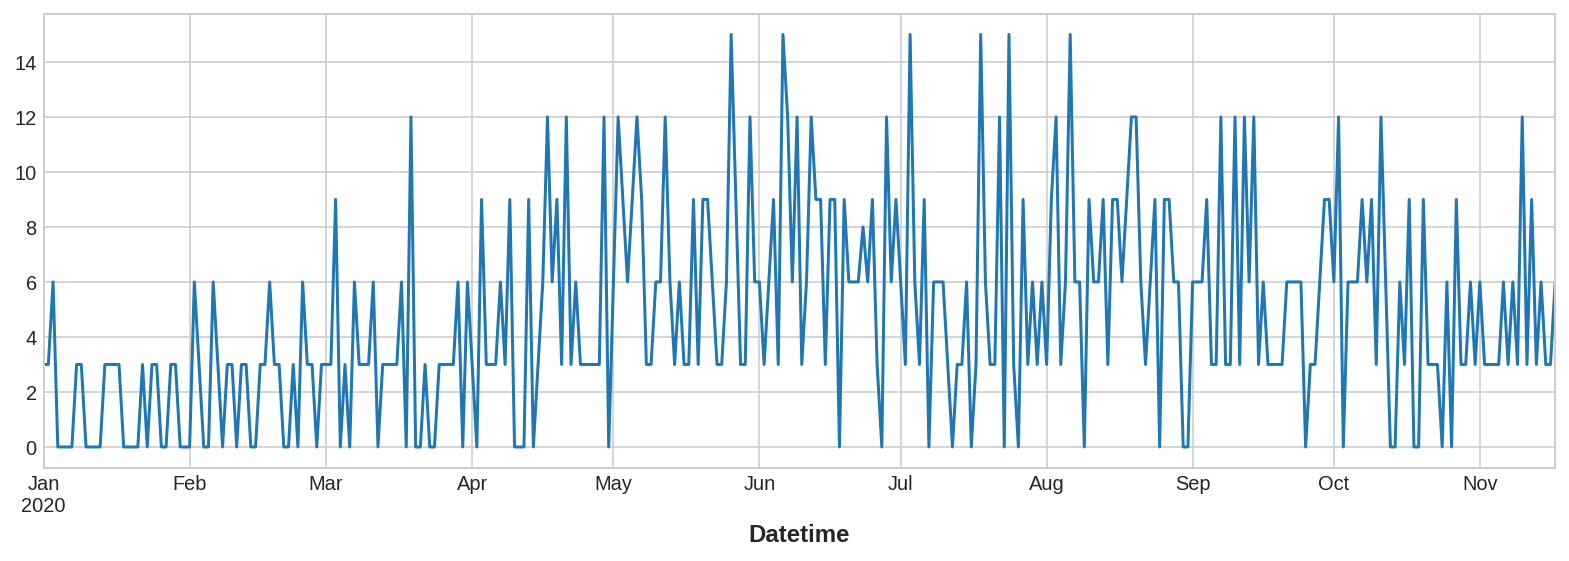

In [9]:
# Plots count of large negative numbers day wise
train[train["Total Cloud Cover [%]"] < -1].resample("D")["Total Cloud Cover [%]"].count().plot()

In [10]:
# Replaces large negative values with missing values, and interpolates linearly
for resample in train.resample("D")["Total Cloud Cover [%]"]:
    observed_cloud_coverage = resample[1][resample[1] != -1]
    observed_cloud_coverage[observed_cloud_coverage < 0] = np.nan
    observed_cloud_coverage.interpolate(method="linear", inplace=True)
    train["Total Cloud Cover [%]"].update(observed_cloud_coverage)

In [11]:
# Checks the statistics of the newly interpolated column
train["Total Cloud Cover [%]"].describe()

count    527040.000000
mean         22.762201
std          34.999395
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          36.000000
max         100.000000
Name: Total Cloud Cover [%], dtype: float64

In [12]:
# Upon finding large native values for another column for snow depth, too, checks for basic statistics of the column
train["Snow Depth [cm]"].describe()

count    527040.000000
mean         -3.301760
std         199.263767
min       -7999.000000
25%           0.102000
50%           0.643000
75%           1.043000
max          28.430000
Name: Snow Depth [cm], dtype: float64

<AxesSubplot:xlabel='Datetime'>

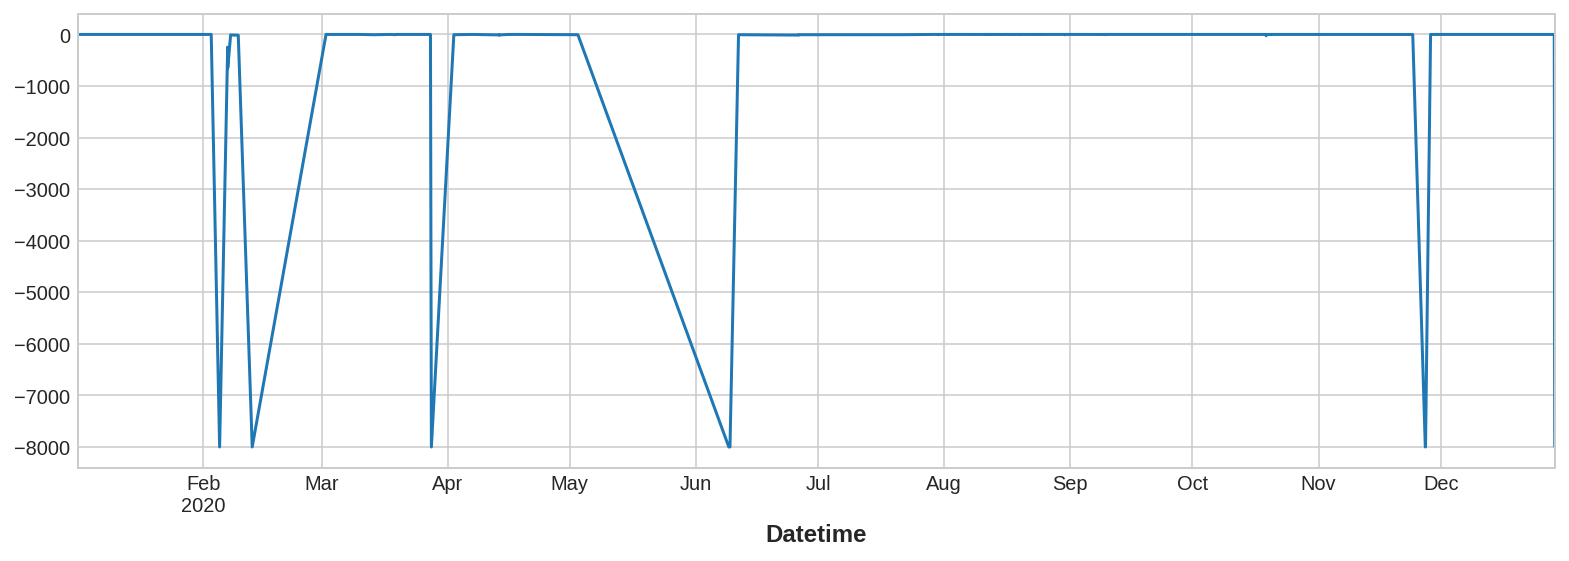

In [13]:
# Plots snow depth when it is negative
train[train["Snow Depth [cm]"] < 0]["Snow Depth [cm]"].plot()

<AxesSubplot:xlabel='Datetime'>

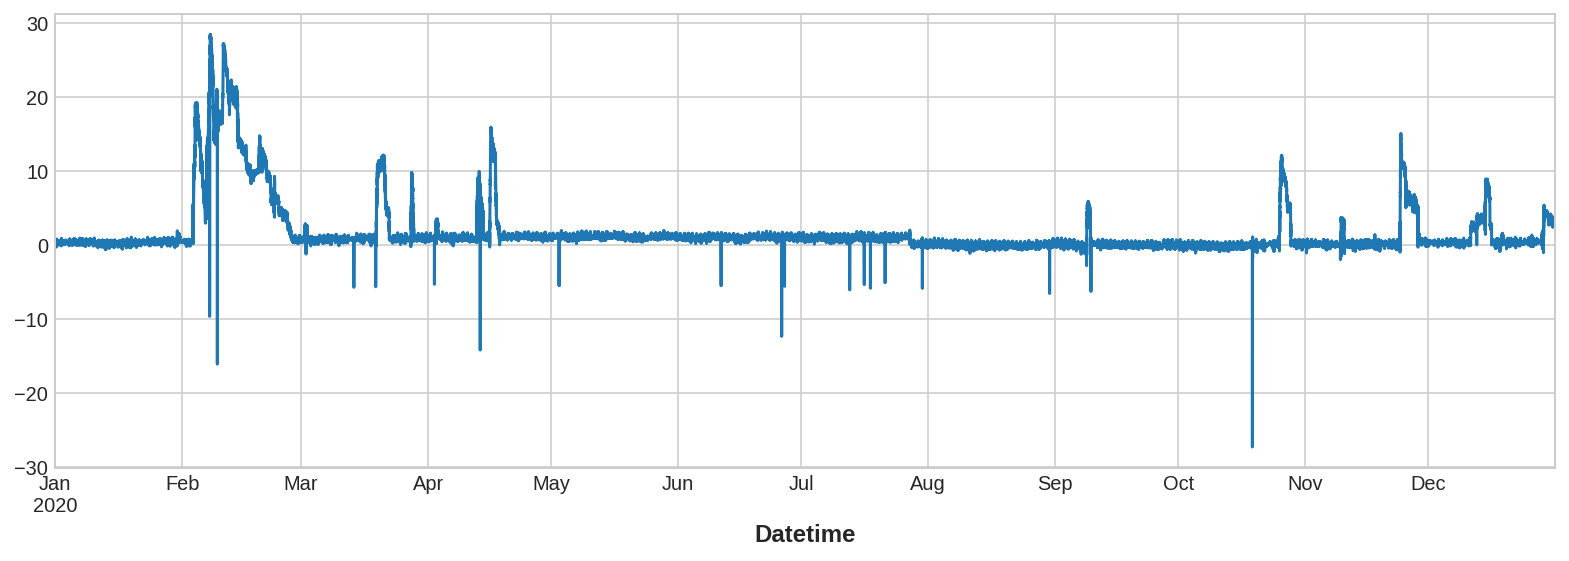

In [14]:
# Plots snow depth distribution when it is more than -100
train[train["Snow Depth [cm]"] > -100]["Snow Depth [cm]"].plot()

In [15]:
# Calculates distribution of negative snow depth 
train[train["Snow Depth [cm]"] < 0]["Snow Depth [cm]"].groupby(
    pd.cut(train[train["Snow Depth [cm]"] < 0]["Snow Depth [cm]"], list(range(-1000, 50, 50)))).count()

Snow Depth [cm]
(-1000, -950]        0
(-950, -900]         0
(-900, -850]         0
(-850, -800]         0
(-800, -750]         0
(-750, -700]         0
(-700, -650]         1
(-650, -600]         0
(-600, -550]         0
(-550, -500]         0
(-500, -450]         0
(-450, -400]         0
(-400, -350]         1
(-350, -300]         0
(-300, -250]         0
(-250, -200]         1
(-200, -150]         0
(-150, -100]         0
(-100, -50]          0
(-50, 0]         99857
Name: Snow Depth [cm], dtype: int64

In [16]:
# Replaces negative snow depth less than -100 with missing value and then interpolates linearly

train["Snow Depth [cm]"].loc[train["Snow Depth [cm]"] < -100] = np.nan

train["Snow Depth [cm]"].interpolate(method="linear", inplace=True)

<AxesSubplot:xlabel='Datetime'>

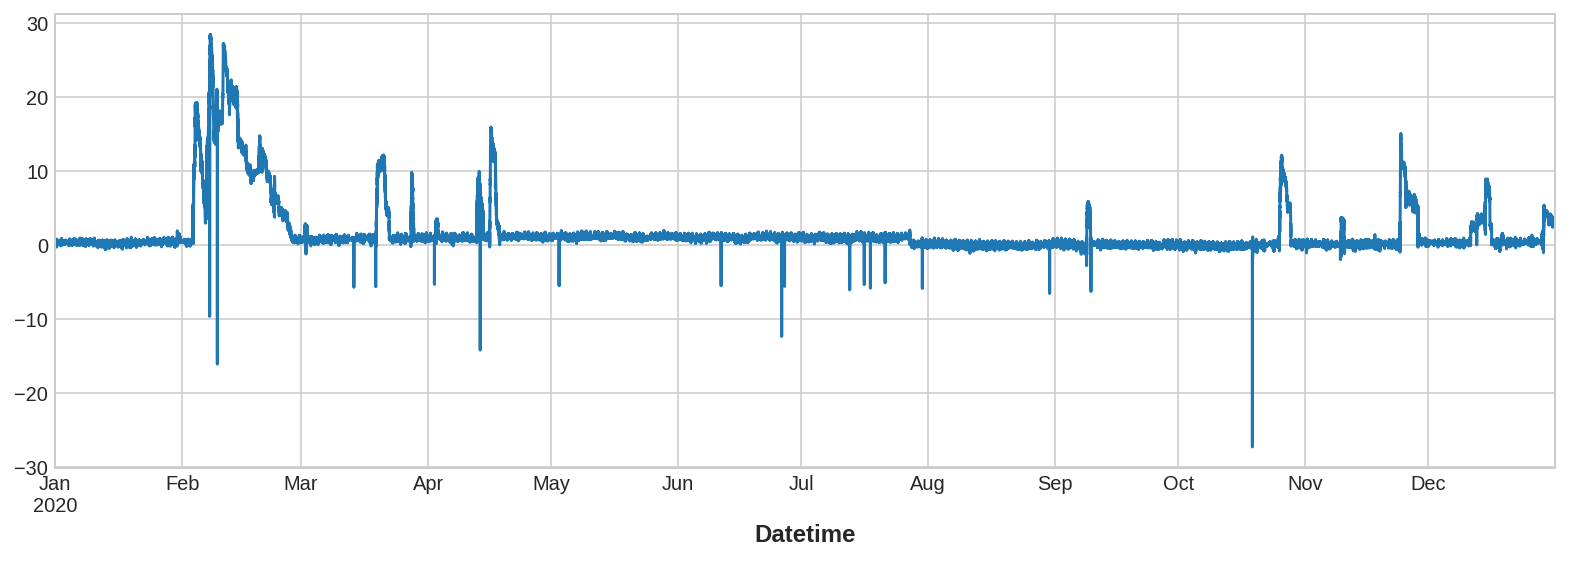

In [17]:
# Re=plots to ensure interpolates did not affect major distribution for snow depth of values of acceptable range
train["Snow Depth [cm]"].plot()

In [18]:
# Checks basic statistics of train dataset post interpolating for columns cloud coverage and snow depth
train.describe()

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
count,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000
mean,196.971081,237.119295,180.000016,11.829286,4.610521,-3.115536,40.664133,22.762201,2.855863,168.420883,816.876516,0.370496,1.665555,0.064295,0.131975
std,290.616298,367.803389,100.772041,10.703063,6.965858,7.339865,24.196340,34.999395,2.081439,116.719968,5.114894,1.871185,3.781009,0.242353,0.186085
min,-4.764200,-12.403300,0.000120,-16.690000,-17.351000,-24.830000,4.210000,-1.000000,0.000000,0.000000,794.918000,0.000000,-27.330000,0.000000,0.000000
25%,-1.106560,-0.197818,89.724415,3.222000,-0.877000,-8.653000,22.300000,-1.000000,1.450000,43.280000,813.736000,0.000000,0.103000,0.000000,0.000000
50%,4.909625,0.256763,179.991490,11.910000,4.727000,-3.643000,33.790000,-1.000000,2.450000,181.200000,817.305000,0.000000,0.645000,0.000000,0.000000
75%,335.747500,518.209250,270.267272,20.350000,10.788000,2.208000,53.530000,36.000000,3.700000,282.200000,820.278250,0.000000,1.043000,0.000000,0.203600
max,1428.650000,1069.200000,359.998560,36.320000,19.416000,17.418000,100.100000,100.000000,24.200000,360.000000,847.963000,28.190000,28.430000,1.000000,2.000000


In [35]:
# Inserts an additional feature column: 
#    value 1 indicates cloud coverage is available, and 
#    value 0 indicates cloud coverage is not available
train.insert(
    loc=train.columns.get_loc("Total Cloud Cover [%]"), 
    column="Total Cloud Cover Available", 
    value=train["Total Cloud Cover [%]"].apply(lambda coverage:
                                    1 if coverage >= 0 else 0))

In [ ]:
# Saves the features engineered train dataset
train.to_csv("./dataset/train/train_interpolated.csv", index=True)

In [25]:
# Reloads the featured engineered train dataset
train = pd.read_csv(
    "./dataset/train/train_interpolated.csv", 
    parse_dates=True, 
    index_col="Datetime", 
    infer_datetime_format=True).to_period()

In [26]:
def flag_val_samples(target_col, validation_ratio=0.2):
    # Flags valid samples
    
    # Parameters:
    #    target_col (pandas.core.series.Series): target column containing shifted values according to target horizon
    #    validation_ratio (float): validation ratio/spit. The default is 0.2 i.e. 20%
    
    # Returns:
    #    Returns a new series of bool type containing TRUE against valid samples.
    
    val_samples = pd.Series(False, index=target_col.index)
    available_targets = target_col[target_col != -1]
    random_selected_samples = available_targets.sample(frac = validation_ratio, random_state = 47)
    val_samples[random_selected_samples.index] = True
    return val_samples

In [27]:
validation_ratio = 0.2

In [28]:
# Shifts values by target horizons and marks against valid samples

train["Target_Horizon_30"] = train["Total Cloud Cover [%]"].shift(-30, fill_value=-1)
train["Target_Horizon_30_Val_Flag"] = flag_val_samples(train["Target_Horizon_30"])

train["Target_Horizon_60"] = train["Total Cloud Cover [%]"].shift(-60, fill_value=-1)
train["Target_Horizon_60_Val_Flag"] = flag_val_samples(train["Target_Horizon_60"])

train["Target_Horizon_90"] = train["Total Cloud Cover [%]"].shift(-90, fill_value=-1)
train["Target_Horizon_90_Val_Flag"] = flag_val_samples(train["Target_Horizon_90"])

train["Target_Horizon_120"] = train["Total Cloud Cover [%]"].shift(-120, fill_value=-1)
train["Target_Horizon_120_Val_Flag"] = flag_val_samples(train["Target_Horizon_120"])

## Modeling & Evaluation

In [29]:
# Stores model features into list
model_features = train.columns[:16]

In [30]:
# Standard scales features

model_features_scaler = StandardScaler().fit(train[model_features])
train[model_features] = model_features_scaler.transform(train[model_features])

In [31]:
def sample_generator(
    data, lookback, horizon_col_name, val_flag_col_name, val_samples=False, steps=1, batch_size=128):
    
    # Generates samples

    # Inputs:
    #     data (pandas.core.frame.DataFrame): data to generate sample from
    #     lookback (int): Number of timesteps go back in time
    #     horizon_col_name (string): Column name of the series containing target horizon
    #     val_flag_col_name (string): Column name of series containing validation flag for the specified horizon
    #     val_samples (bool): False to return training samples and True to return validation samples. Default is False.
    #     steps (int): <not implemented>
    #     batch_size (int): Number of samples in each yield

    # Returns:
    #     Yields samples each containing samples specified by parameter batch_size
    
    while True:
        samples = []
        targets = []
        rolling_windows = train.rolling(lookback, min_periods=lookback)
        for window in rolling_windows:
            if window.shape[0] != lookback:
                continue
            
            if ((window.iloc[-1][horizon_col_name] != -1) and (window.iloc[-1][val_flag_col_name] != val_samples)):
                samples.append(window[model_features])
                targets.append(window.iloc[-1][horizon_col_name])
                
            if len(samples) == batch_size:
                yield np.asarray(samples), np.asarray(targets)
                samples.clear()
                targets.clear()
                
        yield np.asarray(samples), np.asarray(targets)

In [32]:
# Sets required variables

lookback = 361
step = 1
batch_size=128

### Modeling to Predict Cloud Coverage at 30 Minutes Horizon

In [71]:
# Creates generators for generating samples with target at 30 minutes horizon for both training and validation

horizon_30_train_sample_generator = sample_generator(
    data=train, lookback=lookback, 
    horizon_col_name="Target_Horizon_30", val_flag_col_name="Target_Horizon_30_Val_Flag",
    val_samples=False, steps=1, batch_size=batch_size)

horizon_30_val_sample_generator = sample_generator(
    data=train, lookback=lookback, 
    horizon_col_name="Target_Horizon_30", val_flag_col_name="Target_Horizon_30_Val_Flag",
    val_samples=True, steps=1, batch_size=batch_size)

In [72]:
# Calculates number of steps to call to iterate all samples for both training and validation data

steps_per_epoch = round((train[train["Target_Horizon_30"] != -1].shape[0] - lookback + 1) / batch_size)
validation_steps = round(steps_per_epoch * validation_ratio)

In [73]:
# Views the calculated steps
steps_per_epoch, validation_steps

(1968, 394)

In [74]:
# Creates neural network model to predict target at 30 minutes horizon
# Note: Output dimension for second layer GRU should have been 64, but was set to 32 mistakenly.

model = Sequential()
model.add(layers.Input(shape=(lookback,len(model_features))))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(32, activation="relu"))
model.add(layers.Dense(1))

In [75]:
# Checks model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 361, 64)           15744     
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 25,185
Trainable params: 25,185
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Compiles the model specifying optimizer, loss function and metric
model.compile(optimizer="adam", loss="mse", metrics="mae")

In [78]:
# Sets model name
model_name = "horizon-30_gru-64+gru-32-relu+dense" + "_" + datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")

# Fits the model
history = model.fit(
            horizon_30_train_sample_generator, 
            steps_per_epoch=steps_per_epoch, 
            validation_data=horizon_30_val_sample_generator,
            validation_steps=validation_steps,
            epochs=1,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=3, mode="min", restore_best_weights=True),
                ModelCheckpoint(filepath="./models/"+model_name, monitor="val_loss", save_best_only=True, save_weights_only=True),
                TensorBoard(
                    log_dir="./logs/"+model_name, 
                    histogram_freq=1, 
                    update_freq=1)]
)

2021-11-07 19:46:02.771185: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 19:46:02.771249: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-07 19:46:02.772239: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


   1/1968 [..............................] - ETA: 1:24:17 - loss: 2922.8467 - mae: 39.9517

2021-11-07 19:46:06.007207: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 19:46:06.007248: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/1968 [..............................] - ETA: 19:03 - loss: 1538.9020 - mae: 25.4448  

2021-11-07 19:46:06.635794: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-07 19:46:06.759969: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-07 19:46:06.909957: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/horizon-30_gru-64+gru-32-relu+dense_2021.11.07-19:46:02/train/plugins/profile/2021_11_07_19_46_06

2021-11-07 19:46:07.031021: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/horizon-30_gru-64+gru-32-relu+dense_2021.11.07-19:46:02/train/plugins/profile/2021_11_07_19_46_06/avita-pura-ns14a6.trace.json.gz
2021-11-07 19:46:07.082702: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/horizon-30_gru-64+gru-32-relu+dense_2021.11.07-19:46:02/train/plugins/profile/2021_11_07_19_46_06

2021-11-07 19:46:07.082850: I tensorflow/core/profiler/rpc/client/save_prof

1968/1968 [==============================] - 1318s 669ms/step - loss: 374.0239 - mae: 13.2927 - val_loss: 270.8473 - val_mae: 11.3620


### Modeling to Predict Cloud Coverage at 60 Minutes Horizon

In [79]:
# Creates generators for generating samples with target at 60 minutes horizon for both training and validation

horizon_60_train_sample_generator = sample_generator(
    data=train, lookback=lookback, 
    horizon_col_name="Target_Horizon_60", val_flag_col_name="Target_Horizon_60_Val_Flag",
    val_samples=False, steps=1, batch_size=batch_size)

horizon_60_val_sample_generator = sample_generator(
    data=train, lookback=lookback, 
    horizon_col_name="Target_Horizon_60", val_flag_col_name="Target_Horizon_60_Val_Flag",
    val_samples=True, steps=1, batch_size=batch_size)

In [80]:
# Calculates number of steps to call to iterate all samples for both training and validation data

steps_per_epoch = round((train[train["Target_Horizon_60"] != -1].shape[0] - lookback + 1) / batch_size)
validation_steps = round(steps_per_epoch * validation_ratio)

In [81]:
# Views the calculated steps
steps_per_epoch, validation_steps

(1968, 394)

In [83]:
# Creates neural network model to predict target at 60 minutes horizon

model = Sequential()
model.add(layers.Input(shape=(lookback,len(model_features))))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64, activation="relu"))
model.add(layers.Dense(1))

In [84]:
# Checks model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 361, 64)           15744     
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 40,769
Trainable params: 40,769
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Compiles the model specifying optimizer, loss function and metric
model.compile(optimizer="adam", loss="mse", metrics="mae")

In [87]:
# Sets model name
model_name = "horizon-60_gru-64+gru-64-relu+dense" + "_" + datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")

# Fits the model
history = model.fit(
            horizon_60_train_sample_generator, 
            steps_per_epoch=steps_per_epoch, 
            validation_data=horizon_60_val_sample_generator,
            validation_steps=validation_steps,
            epochs=1,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=3, mode="min", restore_best_weights=True),
                ModelCheckpoint(filepath="./models/"+model_name, monitor="val_loss", save_best_only=True, save_weights_only=True),
                TensorBoard(
                    log_dir="./logs/"+model_name, 
                    histogram_freq=1, 
                    update_freq=1)]
)

2021-11-07 20:15:54.873707: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 20:15:54.873784: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-07 20:15:54.875048: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


   1/1968 [..............................] - ETA: 1:27:20 - loss: 2917.2383 - mae: 40.0118

2021-11-07 20:15:58.126853: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 20:15:58.126901: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/1968 [..............................] - ETA: 19:14 - loss: 1541.4176 - mae: 25.7133  

2021-11-07 20:15:58.899569: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-07 20:15:59.070118: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-07 20:15:59.217391: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/horizon-60_gru-64+gru-64-relu+dense_2021.11.07-20:15:54/train/plugins/profile/2021_11_07_20_15_59

2021-11-07 20:15:59.350948: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/horizon-60_gru-64+gru-64-relu+dense_2021.11.07-20:15:54/train/plugins/profile/2021_11_07_20_15_59/avita-pura-ns14a6.trace.json.gz
2021-11-07 20:15:59.415751: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/horizon-60_gru-64+gru-64-relu+dense_2021.11.07-20:15:54/train/plugins/profile/2021_11_07_20_15_59

2021-11-07 20:15:59.415958: I tensorflow/core/profiler/rpc/client/save_prof

1968/1968 [==============================] - 1535s 779ms/step - loss: 568.8441 - mae: 17.6378 - val_loss: 469.7842 - val_mae: 15.2505


### Modeling to Predict Cloud Coverage at 90 Minutes Horizon

In [88]:
# Creates generators for generating samples with target at 90 minutes horizon for both training and validation

horizon_90_train_sample_generator = sample_generator(
    data=train, lookback=lookback, 
    horizon_col_name="Target_Horizon_90", val_flag_col_name="Target_Horizon_90_Val_Flag",
    val_samples=False, steps=1, batch_size=batch_size)

horizon_90_val_sample_generator = sample_generator(
    data=train, lookback=lookback, 
    horizon_col_name="Target_Horizon_90", val_flag_col_name="Target_Horizon_90_Val_Flag",
    val_samples=True, steps=1, batch_size=batch_size)

In [89]:
# Calculates number of steps to call to iterate all samples for both training and validation data

steps_per_epoch = round((train[train["Target_Horizon_90"] != -1].shape[0] - lookback + 1) / batch_size)
validation_steps = round(steps_per_epoch * validation_ratio)

In [90]:
# Views the calculated steps
steps_per_epoch, validation_steps

(1968, 394)

In [91]:
# Creates neural network model to predict target at 90 minutes horizon

model = Sequential()
model.add(layers.Input(shape=(lookback,len(model_features))))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64, activation="relu"))
model.add(layers.Dense(1))

In [92]:
# Checks model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 361, 64)           15744     
_________________________________________________________________
gru_11 (GRU)                 (None, 64)                24960     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 40,769
Trainable params: 40,769
Non-trainable params: 0
_________________________________________________________________


In [93]:
# Compiles the model specifying optimizer, loss function and metric
model.compile(optimizer="adam", loss="mse", metrics="mae")

In [94]:
# Sets model name
model_name = "horizon-90_gru-64+gru-64-relu+dense" + "_" + datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")

# Fits the model
history = model.fit(
            horizon_90_train_sample_generator, 
            steps_per_epoch=steps_per_epoch, 
            validation_data=horizon_90_val_sample_generator,
            validation_steps=validation_steps,
            epochs=1,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=3, mode="min", restore_best_weights=True),
                ModelCheckpoint(filepath="./models/"+model_name, monitor="val_loss", save_best_only=True, save_weights_only=True),
                TensorBoard(
                    log_dir="./logs/"+model_name, 
                    histogram_freq=1, 
                    update_freq=1)]
)

2021-11-07 20:42:49.828736: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 20:42:49.828802: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-07 20:42:49.829352: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


   1/1968 [..............................] - ETA: 1:27:35 - loss: 2942.7769 - mae: 40.3405

2021-11-07 20:42:53.087493: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 20:42:53.087538: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/1968 [..............................] - ETA: 19:02 - loss: 1556.0972 - mae: 25.9680  

2021-11-07 20:42:53.867395: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-07 20:42:53.994236: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-07 20:42:54.164083: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/horizon-90_gru-64+gru-64-relu+dense_2021.11.07-20:42:49/train/plugins/profile/2021_11_07_20_42_53

2021-11-07 20:42:54.297904: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/horizon-90_gru-64+gru-64-relu+dense_2021.11.07-20:42:49/train/plugins/profile/2021_11_07_20_42_53/avita-pura-ns14a6.trace.json.gz
2021-11-07 20:42:54.353933: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/horizon-90_gru-64+gru-64-relu+dense_2021.11.07-20:42:49/train/plugins/profile/2021_11_07_20_42_53

2021-11-07 20:42:54.354079: I tensorflow/core/profiler/rpc/client/save_prof

1968/1968 [==============================] - 1552s 787ms/step - loss: 701.9638 - mae: 20.3966 - val_loss: 630.3488 - val_mae: 18.3554


### Modeling to Predict Cloud Coverage at 120 Minutes Horizon

In [95]:
# Creates generators for generating samples with target at 120 minutes horizon for both training and validation

horizon_120_train_sample_generator = sample_generator(
    data=train, lookback=lookback, 
    horizon_col_name="Target_Horizon_120", val_flag_col_name="Target_Horizon_120_Val_Flag",
    val_samples=False, steps=1, batch_size=batch_size)

horizon_120_val_sample_generator = sample_generator(
    data=train, lookback=lookback, 
    horizon_col_name="Target_Horizon_120", val_flag_col_name="Target_Horizon_120_Val_Flag",
    val_samples=True, steps=1, batch_size=batch_size)

In [96]:
# Calculates number of steps to call to iterate all samples for both training and validation data

steps_per_epoch = round((train[train["Target_Horizon_120"] != -1].shape[0] - lookback + 1) / batch_size)
validation_steps = round(steps_per_epoch * validation_ratio)

In [97]:
# Views the calculated steps
steps_per_epoch, validation_steps

(1968, 394)

In [98]:
# Creates neural network model to predict target at 120 minutes horizon

model = Sequential()
model.add(layers.Input(shape=(lookback,len(model_features))))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64, activation="relu"))
model.add(layers.Dense(1))

In [99]:
# Checks model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 361, 64)           15744     
_________________________________________________________________
gru_13 (GRU)                 (None, 64)                24960     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 40,769
Trainable params: 40,769
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Compiles the model specifying optimizer, loss function and metric
model.compile(optimizer="adam", loss="mse", metrics="mae")

In [101]:
# Sets model name
model_name = "horizon-120_gru-64+gru-64-relu+dense" + "_" + datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")

# Fits the model
history = model.fit(
            horizon_120_train_sample_generator, 
            steps_per_epoch=steps_per_epoch, 
            validation_data=horizon_120_val_sample_generator,
            validation_steps=validation_steps,
            epochs=1,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=3, mode="min", restore_best_weights=True),
                ModelCheckpoint(filepath="./models/"+model_name, monitor="val_loss", save_best_only=True, save_weights_only=True),
                TensorBoard(
                    log_dir="./logs/"+model_name, 
                    histogram_freq=1, 
                    update_freq=1)]
)

2021-11-07 21:11:04.474123: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 21:11:04.474206: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-07 21:11:04.474334: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


   1/1968 [..............................] - ETA: 1:27:53 - loss: 2909.8711 - mae: 39.7614

2021-11-07 21:11:07.716885: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 21:11:07.716961: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/1968 [..............................] - ETA: 22:36 - loss: 1533.4783 - mae: 25.3876  

2021-11-07 21:11:08.654664: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-07 21:11:08.778040: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-07 21:11:08.942969: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/horizon-120_gru-64+gru-64-relu+dense_2021.11.07-21:11:04/train/plugins/profile/2021_11_07_21_11_08

2021-11-07 21:11:09.078378: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/horizon-120_gru-64+gru-64-relu+dense_2021.11.07-21:11:04/train/plugins/profile/2021_11_07_21_11_08/avita-pura-ns14a6.trace.json.gz
2021-11-07 21:11:09.150604: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/horizon-120_gru-64+gru-64-relu+dense_2021.11.07-21:11:04/train/plugins/profile/2021_11_07_21_11_08

2021-11-07 21:11:09.150789: I tensorflow/core/profiler/rpc/client/save_p

1968/1968 [==============================] - 1507s 765ms/step - loss: 795.4077 - mae: 22.2051 - val_loss: 753.5236 - val_mae: 20.4832


## Sumbission

In [102]:
# Sets test directory path containing test samples
test_dir = "./dataset/test"

In [116]:
# Creates a list to contain test samples as tuple having first element as sample index and last element for sample itself
test_samples = []

# Iterates over test directories and adds test samples into list
for dir in os.listdir(test_dir):
    test_data_file = os.path.join(test_dir, dir, "weather_data.csv")
    test = pd.read_csv(test_data_file)
    
    # Drops time column as not required because observations in each sample are already in sequence
    test.drop(["Time [Mins]"], axis=1, inplace=True)
    
    # Interpolates values in these two columns as required
    
    observed_cloud_coverage = test[test["Total Cloud Cover [%]"] != -1]["Total Cloud Cover [%]"].copy()
    observed_cloud_coverage.loc[observed_cloud_coverage < 0] = np.nan
    observed_cloud_coverage.interpolate(method="linear", inplace=True)
    test["Total Cloud Cover [%]"].update(observed_cloud_coverage)
    
    test.loc[test["Albedo (CMP11)"] < 0, "Albedo (CMP11)"] = np.nan
    test["Albedo (CMP11)"].interpolate(method="linear", inplace=True)
    
    # Inserts a column as additional feature, as already done with training data, to indicate if target is available
    test.insert(
        loc=test.columns.get_loc("Total Cloud Cover [%]"), 
        column="Total Cloud Cover Available", 
        value=test["Total Cloud Cover [%]"].apply(lambda coverage:
                                        1 if coverage >= 0 else 0))
    
    # Scales the features
    test[model_features] = model_features_scaler.transform(test[model_features])
    
    # Appends the test sample into the list
    test_samples.append((int(dir), test))

In [117]:
# Sorts the test samples according to their index number to match submission sequence
test_samples = sorted(test_samples, key=lambda scenario: scenario[0])

# Post sorting, only test samples out of thier tuples are extracted
test_samples = [test_sample[1] for test_sample in test_samples]

# Converts test samples 3D numpy array to be compatible for model prediction
test_samples = np.asarray(test_samples)

In [128]:
# Checks the shape of the numpy array
test_samples.shape

(300, 361, 16)

### Predicting Cloud Coverage

In [136]:
# Note: This step could have been avoided if output nodes were 64 in second layer in each model.

model = Sequential()
model.add(layers.Input(shape=(lookback,len(model_features))))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(32, activation="relu"))
model.add(layers.Dense(1))
model.compile(optimizer="adam", loss="mse", metrics="mae")

In [137]:
# Loads weights for best model to predict at 30 minutes horizon
model_name = "./models/horizon-30_gru-64+gru-32-relu+dense_2021.11.07-19:46:02"
model.load_weights(model_name)

# Predicting cloud coverage at 30 minutes horizon
horizon_30_predictions = model.predict(test_samples).reshape(300,)

In [138]:
# Note: This step could have been avoided if output nodes were 64 in second layer in each model.

model = Sequential()
model.add(layers.Input(shape=(lookback,len(model_features))))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64, activation="relu"))
model.add(layers.Dense(1))
model.compile(optimizer="adam", loss="mse", metrics="mae")

In [139]:
# Loads weights for best model to predict at 60 minutes horizon
model_name = "./models/horizon-60_gru-64+gru-64-relu+dense_2021.11.07-20:15:54"
model.load_weights(model_name)

# Predicting cloud coverage at 60 minutes horizon
horizon_60_predictions = model.predict(test_samples).reshape(300,)

In [140]:
# Loads weights for best model to predict at 90 minutes horizon
model_name = "./models/horizon-90_gru-64+gru-64-relu+dense_2021.11.07-20:42:49"
model.load_weights(model_name)

# Predicting cloud coverage at 90 minutes horizon
horizon_90_predictions = model.predict(test_samples).reshape(300,)

In [141]:
# Loads weights for best model to predict at 120 minutes horizon
model_name = "./models/horizon-120_gru-64+gru-64-relu+dense_2021.11.07-21:11:04"
model.load_weights(model_name)

# Predicting cloud coverage at 120 minutes horizon
horizon_120_predictions = model.predict(test_samples).reshape(300,)

In [142]:
# Creates dataframe containing predictions for all four horizons
all_horizon_predictions = pd.DataFrame(
                                {
                                    "scenario_set": range(1, 301),
                                    "30_min_horizon": horizon_30_predictions,
                                    "60_min_horizon": horizon_60_predictions,
                                    "90_min_horizon": horizon_90_predictions,
                                    "120_min_horizon": horizon_120_predictions
                                }
                            )

In [144]:
# Saves the prediction into file
all_horizon_predictions.to_csv("./submission_2-layers-gru.csv", index=False)